In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import statsmodels.api as sm

%matplotlib inline

In [2]:
data = pd.read_csv('electricity.csv')

In [3]:
data.head()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52


In [4]:
data.tail()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
5515,5515,4410.631913,14.70,5515,43,187
5516,5516,4292.029885,14.60,5516,44,188
5517,5517,4231.380523,14.65,5517,45,189
5518,5518,4587.536047,14.70,5518,46,190
5519,5519,4540.230041,14.75,5519,47,191


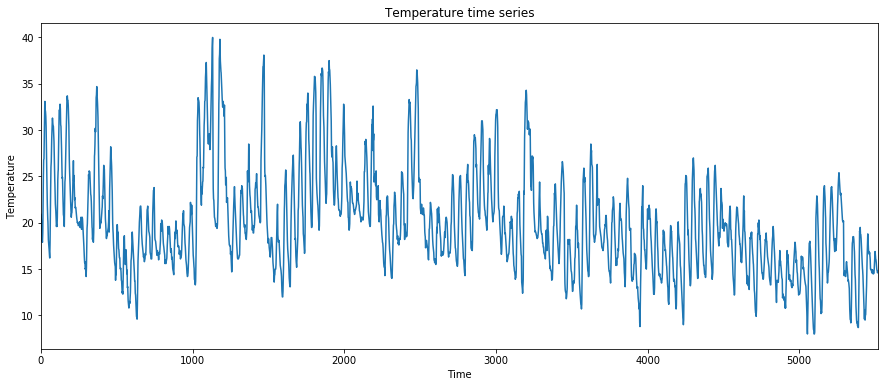

In [5]:
t = data['Temperature']
t.plot(figsize=(15, 6))

plt.title('Temperature time series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

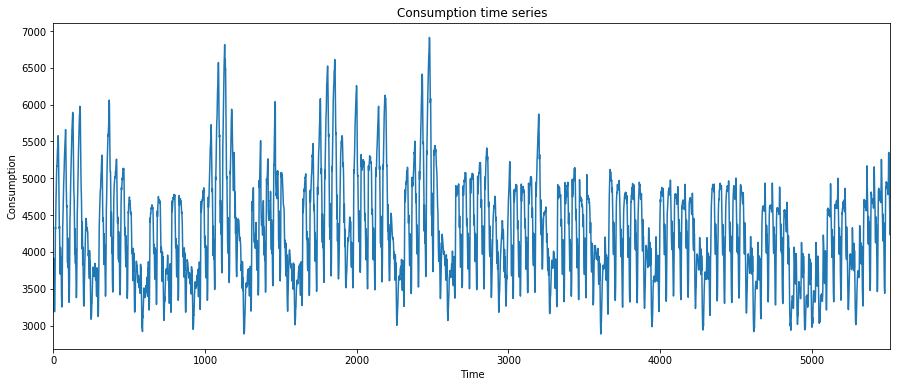

In [6]:
c = data['Consumption']
c.plot(figsize=(15, 6))

plt.title('Consumption time series')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

In [7]:
print(sps.pearsonr(t, c), sps.spearmanr(t, c), sps.kendalltau(t, c))

(0.6665582601612684, 0.0) SpearmanrResult(correlation=0.57805418606949333, pvalue=0.0) KendalltauResult(correlation=0.41337814259124334, pvalue=0.0)


In [8]:
sub_t = t[sps.randint.rvs(0, len(t), size=200)]
sub_c = c[sps.randint.rvs(0, len(c), size=200)]

In [9]:
print(sps.pearsonr(sub_t, sub_c), sps.spearmanr(sub_t, sub_c), sps.kendalltau(sub_t, sub_c))

(-0.087340068733008328, 0.21877782839416882) SpearmanrResult(correlation=-0.075446083706822278, pvalue=0.28832874187387486) KendalltauResult(correlation=-0.051627880948393115, pvalue=0.27761756927820769)


In [10]:
train = data[:48*7]

In [12]:
train.head()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52


In [13]:
train.tail()

,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
331,331,4055.299116,22.60,331,43,43
332,332,3901.053355,22.30,332,44,44
333,333,3829.976659,21.70,333,45,45
334,334,4245.891885,21.10,334,46,46
335,335,4209.528690,20.35,335,47,47


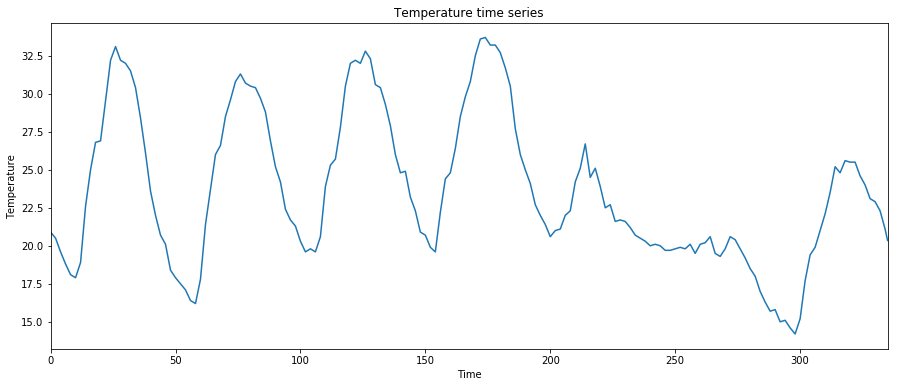

In [14]:
t = train['Temperature']
t.plot(figsize=(15, 6))

plt.title('Temperature time series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

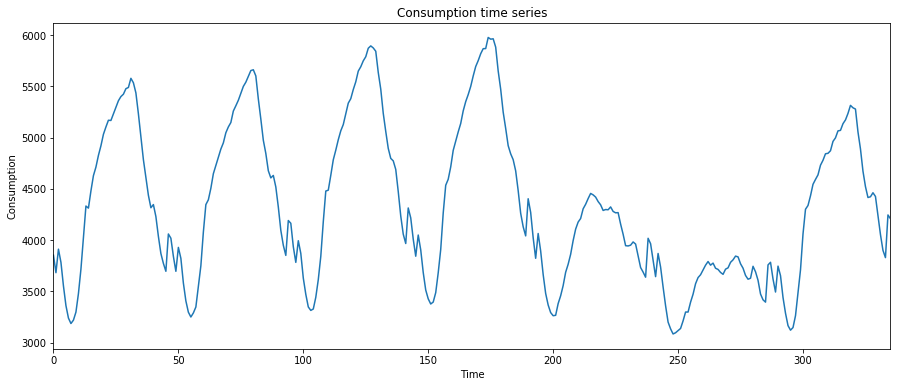

In [15]:
c = train['Consumption']
c.plot(figsize=(15, 6))

plt.title('Consumption time series')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.show()

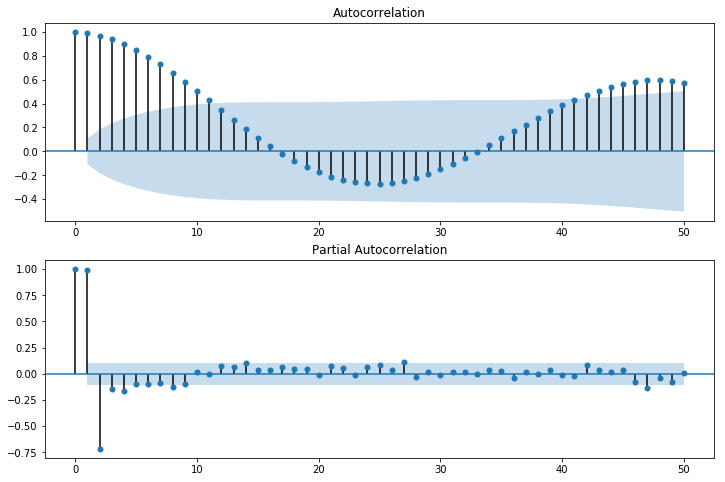

In [20]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(t, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(t, lags=50, ax=ax2)
plt.show()

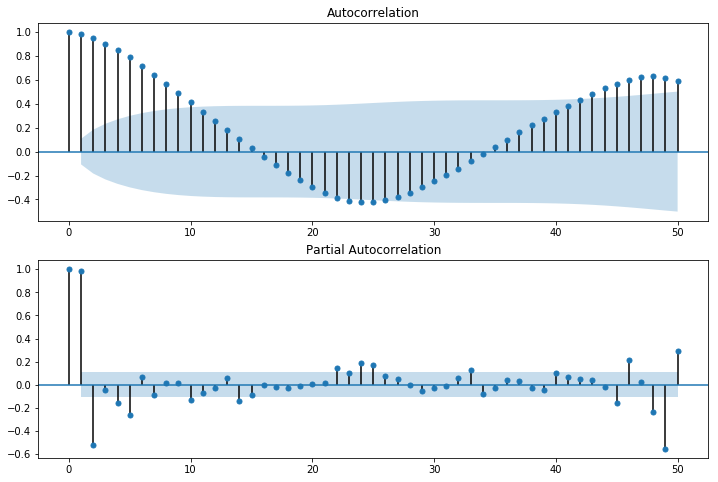

In [21]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(c, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(c, lags=50, ax=ax2)
plt.show()

In [26]:
T = np.array(t)
C = np.array(c)

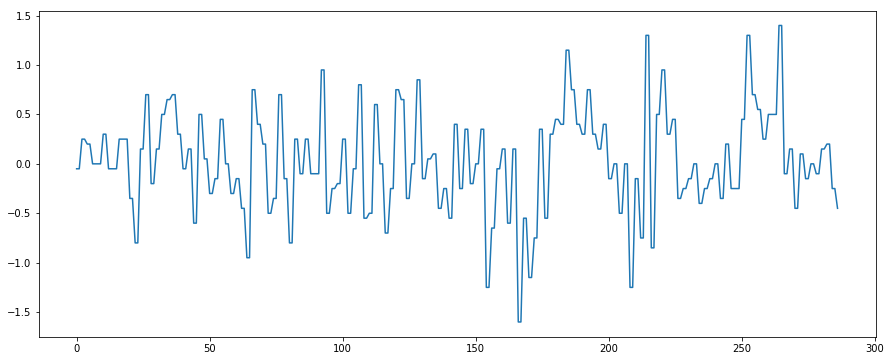

In [33]:
dT = T[48:] - T[:-48]

plt.figure(figsize=(15, 6))
plt.plot(ddT)
plt.show()

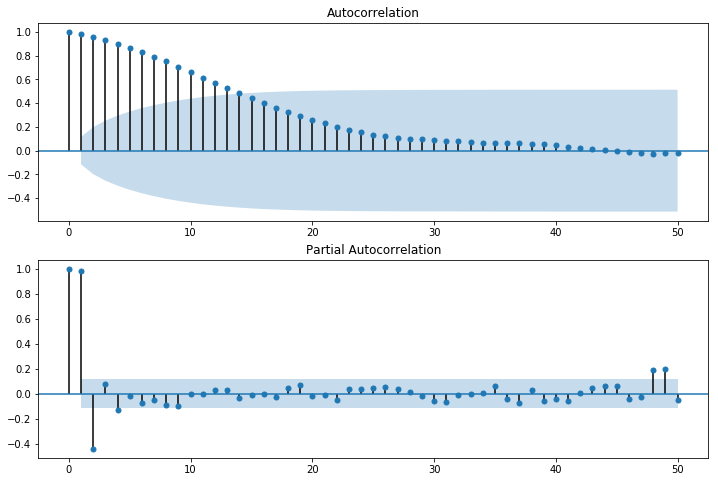

In [34]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dT, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dT, lags=50, ax=ax2)
plt.show()